<a href="https://colab.research.google.com/github/FKz11/Portfolio_Data_Science_2.0/blob/main/Project_Megafon/Project_Megafon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Курсовой проект Megafon

У нас появился запрос из отдела продаж и маркетинга. Как вы знаете «МегаФон» предлагает обширный набор различных услуг своим абонентам. При этом разным пользователям интересны разные услуги. Поэтому необходимо построить  алгоритм, который для каждой пары пользователь-услуга определит вероятность подключения услуги.

**Данные**

В качестве исходных данных вам будет доступна информация об отклике абонентов на предложение подключения одной из услуг. Каждому пользователю может быть сделано несколько предложений в разное время, каждое из которых он может или принять, или отклонить.
Отдельным набором данных будет являться нормализованный анонимизированный набор признаков, характеризующий профиль потребления абонента. Эти данные привязаны к определенному времени, поскольку профиль абонента может меняться с течением времени.

Данные train и test разбиты по периодам – на train доступно 4 месяцев, а на test отложен последующий месяц.

Итого, в качестве входных данных будут представлены:

- data_train.csv: id, vas_id, buy_time, target

- data_test.csv: id, vas_id, buy_time

- features.csv.zip: id, <feature_list> 


И тестовый набор:

- data_test.csv: id, vas_id, buy_time
- target - целевая переменная, где 1 означает подключение услуги, 0 - абонент не подключил услугу соответственно. 
- buy_time - время покупки, представлено в формате timestamp, для работы с этим столбцом понадобится функция datetime.fromtimestamp из модуля datetime.
- id - идентификатор абонента
- vas_id - подключаемая услуга

Примечание: Размер файла features.csv в распакованном виде весит 20 гб, для работы  с ним можно воспользоваться pandas.read_csv, либо можно воспользоваться библиотекой Dask.

**Метрика**

Скоринг будет осуществляться функцией f1, невзвешенным образом, как например делает функция sklearn.metrics.f1_score(…, average=’macro’).

sklearn.metrics.f1_score — scikit-learn 0.22.1 documentation


**Формат представления результата**

1.	Работающая модель в формате pickle, которая принимает файл data_test.csv из корневой папки и записывает в эту же папку файл answers_test.csv. В этом файле должны находится 4 столбца: buy_time, id, vas_id и target. Target можно записать как вероятность подключения услуги.

2.	Код модели можно представить в виде jupyter-ноутбука. 

3.	Презентация в формате .pdf, в которой необходимо отразить:
- Информация о модели, ее параметрах, особенностях и основных результатах.
- Обоснование выбора модели и ее сравнение с альтернативами.
- Принцип составления индивидуальных предложений для выбранных абонентов.

Рекомендуемое количество слайдов – 5 – 10.

Файл answers_test.csv с результатами работы модели, презентацию, ноутбуки и резюме необходимо прикрепить ко второму уроку “курсовой проект”.

### Библиотеки

In [1]:
!pip -qq install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 9.3 MB/s eta 0:00:00


In [2]:
import zipfile

import dask.dataframe as dd
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import plot_confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from sklearn.decomposition import PCA

import pickle

### Данные

In [3]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


df_train и df_test

In [4]:
df_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data_train.csv")
df_train = df_train.drop('Unnamed: 0', axis=1).sort_values('buy_time', ascending=False)
df_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data_test.csv")
df_test = df_test.drop('Unnamed: 0', axis=1).sort_values('buy_time', ascending=False)
df_train.head()

,id,vas_id,buy_time,target
415826,2120971,5.0,1546203600,0.0
347850,4075619,2.0,1546203600,0.0
347990,2446060,2.0,1546203600,0.0
347967,212414,2.0,1546203600,0.0
347934,1175153,2.0,1546203600,0.0


df_features только для пользователей из df_train и df_test

In [5]:
zip_archive = zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/features.csv.zip', "r")
for file_info in zip_archive.infolist():
  zip_archive.extract(file_info, './')

In [6]:
df_features = dd.read_csv("/content/features.csv", sep='\t')

common_users = pd.concat([df_train, df_test]).id.unique()
df_features = df_features[df_features.id.isin(common_users)].compute()
del common_users

df_features = df_features.drop('Unnamed: 0', axis=1).sort_values('buy_time', ascending=False).groupby('id').first().drop('buy_time', axis=1)
df_features.head()

,0,1,2,3,4,5,6,7,8,9,...,243,244,245,246,247,248,249,250,251,252
id,,,,,,,,,,,,,,,,,,,,,
2,-96.799971,229.530888,-110.740786,305.723202,-116.158246,284.61821,-16.08618,-65.076097,-6.78366,-30.006538,...,2300.626154,1492.229208,-21.996269,-35.630448,368.252276,11.167111,7.305572,-12.175933,-0.45614,0.0
4,-96.799971,-323.429112,-110.740786,-376.036798,-116.158246,-397.14179,-16.08618,19.673903,-6.78366,54.743462,...,4806.626154,4140.229208,-25.996269,-37.630448,-35.747724,-20.832889,-0.694428,-7.175933,-0.45614,0.0
15,260.810029,186.710888,249.409214,140.873202,243.991754,119.76821,341.52382,317.953903,-6.78366,-30.006538,...,-381.373846,-613.770792,-24.996269,-31.630448,-212.747724,108.167111,-0.694428,107.824067,13.54386,1.0
16,152.050029,257.220888,195.609214,267.113202,190.191754,246.00821,-16.08618,-65.076097,-6.78366,-30.006538,...,3185.626154,-613.770792,-21.996269,-37.630448,-139.747724,-24.832889,-0.694428,-12.175933,-0.45614,0.0
29,-52.309971,-230.219112,-36.590786,-248.926798,-42.008246,-270.03179,-16.08618,-65.076097,-6.78366,-30.006538,...,-847.373846,-509.770792,-25.996269,-37.630448,-233.747724,-10.832889,-0.694428,2.824067,-0.45614,0.0


merge

In [7]:
df_train = df_train.merge(df_features, on='id', how='left').sort_values('buy_time')
df_train.head()

,id,vas_id,buy_time,target,0,1,2,3,4,5,...,243,244,245,246,247,248,249,250,251,252
831652,2015359,4.0,1531083600,0.0,-75.609971,113.870888,-86.160786,68.893202,-91.578246,47.78821,...,1530.626154,-508.770792,-20.996269,-18.630448,-97.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
819396,2587039,2.0,1531083600,0.0,-94.679971,-72.159112,-108.620786,-124.766798,-114.038246,-145.87179,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
819395,3128142,1.0,1531083600,0.0,-85.609971,-118.199112,-91.070786,-158.086798,-91.408246,-80.89179,...,-410.373846,-53.770792,-20.996269,133.369552,-9.747724,-22.832889,-0.694428,-9.175933,-0.45614,1.0
819394,757373,1.0,1531083600,0.0,158.420029,785.290888,144.479214,783.933202,139.061754,762.82821,...,-977.373846,-613.770792,-25.996269,-37.630448,-304.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
819393,946701,2.0,1531083600,0.0,-96.799971,-81.899112,-110.740786,-134.506798,-116.158246,268.10821,...,-976.373846,-613.770792,-25.996269,-37.630448,-155.747724,-17.832889,-0.694428,-4.175933,-0.45614,0.0


In [8]:
df_train.shape

(831653, 257)

Сохраним df_train и df_features

In [9]:
df_train.to_csv("/content/drive/MyDrive/Colab Notebooks/df_train.csv", index=False)
df_features.to_csv("/content/drive/MyDrive/Colab Notebooks/df_features.csv")

### *** check point ***

Загрузим данные для обучения

In [4]:
df_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/df_train.csv")

### Разбиение на train и val

Данные нельзя премешивать, так как теряется временная зависимость, для валидации нужно взять последнии записи, тогда как для тренировки первые.

In [5]:
val_size = 0.25
df_val = df_train[int(len(df_train) * (1 - val_size)):]
df_train = df_train[:int(len(df_train) * (1 - val_size))]
df_val.head()

,id,vas_id,buy_time,target,0,1,2,3,4,5,...,243,244,245,246,247,248,249,250,251,252
623739,5650,6.0,1544389200,1.0,-96.799971,53.710888,-110.740786,12.963202,-116.158246,-8.14179,...,-965.373846,-611.770792,-25.996269,-19.630448,-270.747724,-23.832889,-0.694428,-12.175933,-0.45614,0.0
623740,1412506,5.0,1544389200,0.0,-96.799971,15.550888,-110.740786,-37.056798,-116.158246,-58.16179,...,4685.626154,2928.229208,-23.996269,-37.630448,1938.252276,83.167111,-0.694428,96.824067,-0.45614,0.0
623741,843569,6.0,1544389200,0.0,-96.799971,-111.569112,-110.740786,-164.176798,-116.158246,-185.28179,...,-920.373846,-556.770792,-18.996269,-37.630448,-264.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
623742,185587,1.0,1544389200,0.0,-87.379971,-369.789112,-101.320786,-419.856798,-106.738246,-440.96179,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
623743,2092745,6.0,1544389200,0.0,237.950029,-51.399112,224.009214,-104.006798,218.591754,-125.11179,...,-977.373846,-613.770792,1562.003731,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0


In [6]:
df_train.shape

(623739, 257)

In [7]:
df_val.shape

(207914, 257)

### Анализ признаков

In [8]:
df_train.dtypes.unique()

array([dtype('int64'), dtype('float64')], dtype=object)

In [9]:
df_train.describe()

,id,vas_id,buy_time,target,0,1,2,3,4,5,...,243,244,245,246,247,248,249,250,251,252
count,6.237390e+05,623739.000000,6.237390e+05,623739.000000,623739.000000,623739.000000,623739.000000,623739.000000,623739.000000,623739.000000,...,623739.000000,623739.000000,623739.000000,623739.000000,623739.000000,623739.000000,623739.000000,623739.000000,623739.000000,623739.000000
mean,2.155849e+06,2.458887,1.536790e+09,0.069494,-0.029137,2.044945,-0.028654,2.490795,0.027183,2.700691,...,3.462541,1.792456,0.924439,0.529939,0.015972,0.237264,-0.023058,0.099906,0.011931,0.258677
std,1.258119e+06,1.895608,3.880209e+06,0.254292,186.561612,387.902563,197.231349,470.686453,215.115015,535.718461,...,3209.504217,2242.413293,1508.547252,311.773613,1299.586071,282.398075,8.530041,218.557362,13.188754,2.308830
min,4.000000e+00,1.000000,1.531084e+09,0.000000,-1151.889971,-1447.969112,-2651.840786,-1488.716798,-2657.258246,-1501.351790,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.456140,0.000000
25%,1.064068e+06,1.000000,1.533503e+09,0.000000,-96.799971,-207.829112,-110.740786,-241.386798,-116.158246,-258.611790,...,-977.373846,-613.770792,-25.996269,-37.630448,-305.747724,-25.832889,-0.694428,-12.175933,-0.456140,0.000000
50%,2.141839e+06,2.000000,1.536527e+09,0.000000,-84.969971,-58.599112,-85.320786,-77.306798,-87.948246,-91.481790,...,-958.373846,-613.770792,-25.996269,-37.630448,-238.747724,-23.832889,-0.694428,-12.175933,-0.456140,0.000000
75%,3.241214e+06,4.000000,1.540156e+09,0.000000,11.660029,121.480888,27.389214,129.878202,29.161754,123.198210,...,-481.373846,-405.770792,-24.996269,-32.630448,-76.747724,-10.832889,-0.694428,-9.175933,-0.456140,1.000000
max,4.362453e+06,9.000000,1.544389e+09,1.000000,10436.540029,58157.290888,10422.599214,122798.583202,12221.941754,122777.478210,...,240076.626154,145602.229208,980158.003731,47086.369552,185850.252276,138539.167111,3865.305572,138552.824067,9489.543860,1743.000000


Найдём неизменяемые признаки

In [10]:
const_features = []
for col in df_train.columns:
  if len(df_train[col].unique()) == 1:
    const_features.append(col)
const_features

['75', '81', '85', '139', '203']

In [11]:
df_train = df_train.drop(const_features, axis=1)
df_train.shape

(623739, 252)

In [12]:
df_val = df_val.drop(const_features, axis=1)
df_val.shape

(207914, 252)

Соотношение классов target

In [13]:
df_train['target'].value_counts()

0.0    580393
1.0     43346
Name: target, dtype: int64

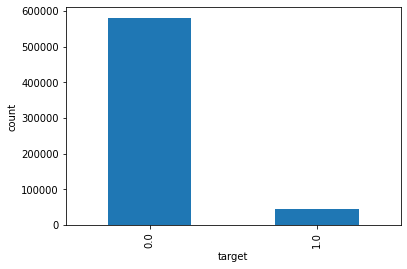

In [14]:
df_train['target'].value_counts().plot(kind="bar")
plt.xlabel('target')
plt.ylabel('count')
plt.show()

In [15]:
disbalance = df_train['target'].value_counts()[0] / df_train['target'].value_counts()[1]
disbalance

13.389770682415909

Виден сильный дизбаланс классов

Подключаемость тарифов

In [16]:
rates = df_train[['vas_id', 'target']].groupby('vas_id').mean().sort_values('target', ascending = False)
rates = rates.rename(columns={"target": "mean_target_vas_id"})
rates

,mean_target_vas_id
vas_id,
6.0,0.452483
4.0,0.248161
9.0,0.222981
5.0,0.033415
2.0,0.028479
8.0,0.028118
1.0,0.020216
7.0,0.016899


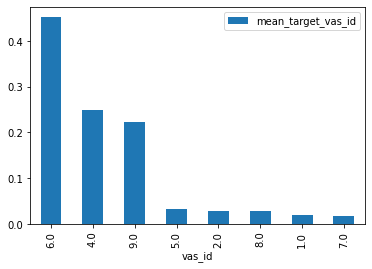

In [17]:
plt.show(rates.plot(kind="bar"))

Первые 3 тарифа явно лидируют

### baseline

1). Пускай абоненты соглашаются только на самый подключаемый тариф, причём всегда

In [18]:
best_rate = rates.index[0]
best_rate

6.0

score on train

In [19]:
predict_target = (df_train.vas_id == best_rate).values.astype(float)
true_target = df_train.target.values
print(classification_report(true_target, predict_target))
print(f"SCORE: {f1_score(true_target, predict_target, average='macro')}")

              precision    recall  f1-score   support

         0.0       0.94      0.98      0.96    580393
         1.0       0.45      0.23      0.30     43346

    accuracy                           0.93    623739
   macro avg       0.70      0.60      0.63    623739
weighted avg       0.91      0.93      0.92    623739

SCORE: 0.633273052496522


score on val

In [20]:
predict_target = (df_val.vas_id == best_rate).values.astype(float)
true_target = df_val.target.values
print(classification_report(true_target, predict_target))
score_bl_1 = f1_score(true_target, predict_target, average='macro')
print(f"SCORE: {score_bl_1}")

              precision    recall  f1-score   support

         0.0       0.99      0.89      0.94    191074
         1.0       0.41      0.87      0.56     16840

    accuracy                           0.89    207914
   macro avg       0.70      0.88      0.75    207914
weighted avg       0.94      0.89      0.91    207914

SCORE: 0.7477021702281252


2). Добавим к предыдущему правилу следующий по популярности тариф

score on train

In [21]:
predict_target = ((df_train.vas_id == best_rate) | (df_train.vas_id == rates.index[1])).values.astype(float)
true_target = df_train.target.values
print(classification_report(true_target, predict_target))
print(f"SCORE: {f1_score(true_target, predict_target, average='macro')}")

              precision    recall  f1-score   support

         0.0       0.97      0.88      0.92    580393
         1.0       0.29      0.69      0.41     43346

    accuracy                           0.86    623739
   macro avg       0.63      0.78      0.67    623739
weighted avg       0.93      0.86      0.89    623739

SCORE: 0.6662444290071196


score on val

In [22]:
predict_target = ((df_val.vas_id == best_rate) | (df_val.vas_id == rates.index[1])).values.astype(float)
true_target = df_val.target.values
print(classification_report(true_target, predict_target))
score_bl_2 = f1_score(true_target, predict_target, average='macro')
print(f"SCORE: {score_bl_2}")

              precision    recall  f1-score   support

         0.0       1.00      0.87      0.93    191074
         1.0       0.40      0.99      0.57     16840

    accuracy                           0.88    207914
   macro avg       0.70      0.93      0.75    207914
weighted avg       0.95      0.88      0.90    207914

SCORE: 0.7497796420417978


3). Добавим к предыдущему правилу следующий по популярности тариф

score on train

In [23]:
predict_target = ((df_train.vas_id == best_rate) | (df_train.vas_id == rates.index[1]) | (df_train.vas_id == rates.index[2])).values.astype(float)
true_target = df_train.target.values
print(classification_report(true_target, predict_target))
print(f"SCORE: {f1_score(true_target, predict_target, average='macro')}")

              precision    recall  f1-score   support

         0.0       0.98      0.87      0.92    580393
         1.0       0.29      0.71      0.41     43346

    accuracy                           0.86    623739
   macro avg       0.63      0.79      0.67    623739
weighted avg       0.93      0.86      0.88    623739

SCORE: 0.6655019273689758


score on val

In [24]:
predict_target = ((df_val.vas_id == best_rate) | (df_val.vas_id == rates.index[1]) | (df_val.vas_id == rates.index[2])).values.astype(float)
true_target = df_val.target.values
print(classification_report(true_target, predict_target))
score_bl_3 = f1_score(true_target, predict_target, average='macro')
print(f"SCORE: {score_bl_3}")

              precision    recall  f1-score   support

         0.0       1.00      0.86      0.93    191074
         1.0       0.39      0.99      0.56     16840

    accuracy                           0.87    207914
   macro avg       0.69      0.93      0.74    207914
weighted avg       0.95      0.87      0.90    207914

SCORE: 0.7434710083305964


4). Пускай абоненты соглашаются только на те тарифы, которые они уже подключали

score on train

In [25]:
train_target_1 = df_train[df_train['target'].astype(bool)]
train_connect_1 = (train_target_1['id'].astype(str) + '_' + train_target_1['vas_id'].astype(str))
train_connect = (df_train['id'].astype(str) + '_' + df_train['vas_id'].astype(str))
predict_target_last = train_connect.isin(train_connect_1).values.astype(float)
true_target = df_train.target.values
print(classification_report(true_target, predict_target_last))
print(f"SCORE: {f1_score(true_target, predict_target_last, average='macro')}")

              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00    580393
         1.0       0.89      1.00      0.94     43346

    accuracy                           0.99    623739
   macro avg       0.95      1.00      0.97    623739
weighted avg       0.99      0.99      0.99    623739

SCORE: 0.9686442435106649


Score не 1, так как бывало 2 одинаковых предложения тарифа одному и тому же абоненты, и на один он соглашался, а на другой нет. А этим алгоритмом мы предпоогаем, что он согласился на оба тарифа.

score on val

In [26]:
val_connect = (df_val['id'].astype(str) + '_' + df_val['vas_id'].astype(str))
predict_target_last = val_connect.isin(train_connect_1).values.astype(float)
true_target = df_val.target.values
print(classification_report(true_target, predict_target_last))
score_bl_4 = f1_score(true_target, predict_target_last, average='macro')
print(f"SCORE: {score_bl_4}")

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96    191074
         1.0       0.04      0.00      0.00     16840

    accuracy                           0.92    207914
   macro avg       0.48      0.50      0.48    207914
weighted avg       0.85      0.92      0.88    207914

SCORE: 0.4791478988493642


5). Совместим 2). и 4). алгоритмы

score on train

In [27]:
predict_target = ((df_train.vas_id == best_rate) | (df_train.vas_id == rates.index[1]) | train_connect.isin(train_connect_1).values.astype(float)).values.astype(float)
true_target = df_train.target.values
print(classification_report(true_target, predict_target))
print(f"SCORE: {f1_score(true_target, predict_target, average='macro')}")

              precision    recall  f1-score   support

         0.0       1.00      0.87      0.93    580393
         1.0       0.37      1.00      0.54     43346

    accuracy                           0.88    623739
   macro avg       0.68      0.94      0.73    623739
weighted avg       0.96      0.88      0.90    623739

SCORE: 0.7333297561194569


score on val

In [28]:
predict_target = ((df_val.vas_id == best_rate) | (df_val.vas_id == rates.index[1]) | val_connect.isin(train_connect_1).values.astype(float)).values.astype(float)
true_target = df_val.target.values
print(classification_report(true_target, predict_target))
score_bl_5 = f1_score(true_target, predict_target, average='macro')
print(f"SCORE: {score_bl_5}")

              precision    recall  f1-score   support

         0.0       1.00      0.87      0.93    191074
         1.0       0.40      0.99      0.57     16840

    accuracy                           0.88    207914
   macro avg       0.70      0.93      0.75    207914
weighted avg       0.95      0.88      0.90    207914

SCORE: 0.749040742428113


Остановимся на 2-ом алгоритме - "Вероятность подключения первых двух тарифов равняется 1 для всех абонентов, вероятность подключения остальных тарифов 0", так как он показал наилуший результат на валидационной выборке.

Примем эту модель за базовую, будем сравнивать результаты основанных на машинном обучении моделей с результатом базовой (SCORE: 0.7497796420417978).

### Future Engineering

#### Target Encoding

Покажим модели подключаемость тарифов напрямую

In [29]:
df_train = df_train.merge(rates, how='left', on='vas_id')
df_val = df_val.merge(rates, how='left', on='vas_id')
df_train.head()

,id,vas_id,buy_time,target,0,1,2,3,4,5,...,244,245,246,247,248,249,250,251,252,mean_target_vas_id
0,2015359,4.0,1531083600,0.0,-75.609971,113.870888,-86.160786,68.893202,-91.578246,47.78821,...,-508.770792,-20.996269,-18.630448,-97.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0,0.248161
1,2587039,2.0,1531083600,0.0,-94.679971,-72.159112,-108.620786,-124.766798,-114.038246,-145.87179,...,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0,0.028479
2,3128142,1.0,1531083600,0.0,-85.609971,-118.199112,-91.070786,-158.086798,-91.408246,-80.89179,...,-53.770792,-20.996269,133.369552,-9.747724,-22.832889,-0.694428,-9.175933,-0.45614,1.0,0.020216
3,757373,1.0,1531083600,0.0,158.420029,785.290888,144.479214,783.933202,139.061754,762.82821,...,-613.770792,-25.996269,-37.630448,-304.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0,0.020216
4,946701,2.0,1531083600,0.0,-96.799971,-81.899112,-110.740786,-134.506798,-116.158246,268.10821,...,-613.770792,-25.996269,-37.630448,-155.747724,-17.832889,-0.694428,-4.175933,-0.45614,0.0,0.028479


### Модели

Так как у нас есть сильный дизбаланс классов, то threshold = 0.5 не является оптимальным, будем перебирать порог с шагом 0.01 пока не найдём лучший, и так для каждой модели

In [30]:
thresholds = [i/100 for i in range(101)]

#### Вспомогательные функции для вывода результата

In [31]:
def pred_train(model, df):
  true_target = df.target.values
  predict_prob_target = model.predict_proba(df.drop('target', axis=1))[:,1]
  best_threshold = thresholds[np.argmax([f1_score(true_target, (predict_prob_target > threshold).astype(float)) for threshold in thresholds])]
  predict_target = (predict_prob_target > best_threshold).astype(float)
  print(classification_report(true_target, predict_target))
  print(f'threshold: {best_threshold}')
  print(f"SCORE: {f1_score(true_target, predict_target, average='macro')}")
  return best_threshold

In [32]:
def pred_val(model, df, threshold):
  true_target = df.target.values
  predict_target = (model.predict_proba(df.drop('target', axis=1))[:,1] > threshold).astype(float)
  score = f1_score(true_target, predict_target, average='macro')
  print(classification_report(true_target, predict_target))
  print(f'threshold: {threshold}')
  print(f"SCORE: {score}")
  return score

#### CatBoost

In [33]:
%%time

cat = CatBoostClassifier(verbose=False, n_estimators=100,
                         random_seed=42, class_weights=[1, disbalance])

cat.fit(df_train.drop('target', axis=1), df_train[['target']])

CPU times: user 1min 23s, sys: 1.96 s, total: 1min 25s
Wall time: 52.9 s


score on train

In [34]:
best_threshold = pred_train(cat, df_train)

              precision    recall  f1-score   support

         0.0       0.97      0.96      0.97    580393
         1.0       0.55      0.59      0.57     43346

    accuracy                           0.94    623739
   macro avg       0.76      0.78      0.77    623739
weighted avg       0.94      0.94      0.94    623739

threshold: 0.84
SCORE: 0.7670412003319382


score on val

In [35]:
score_cat = pred_val(cat, df_val, best_threshold)

              precision    recall  f1-score   support

         0.0       0.99      0.89      0.94    191074
         1.0       0.41      0.87      0.56     16840

    accuracy                           0.89    207914
   macro avg       0.70      0.88      0.75    207914
weighted avg       0.94      0.89      0.91    207914

threshold: 0.84
SCORE: 0.7473469890170675


Уменьшим количество анонимированных признаков с помощью PCA

In [36]:
pca_components = 3
pca = PCA(n_components = pca_components, random_state = 42)

In [37]:
df_train_pca = pd.concat([df_train[['id',	'vas_id',	'buy_time',	'target', 'mean_target_vas_id']], 
                          pd.DataFrame(data=pca.fit_transform(df_train.drop(['id',	'vas_id',	'buy_time',	'target', 'mean_target_vas_id'], axis=1)), 
                                       index=df_train.index, columns=[str(i) for i in range(1, pca_components+1)])], axis=1)
df_val_pca = pd.concat([df_val[['id',	'vas_id',	'buy_time',	'target', 'mean_target_vas_id']], 
                          pd.DataFrame(data=pca.transform(df_val.drop(['id',	'vas_id',	'buy_time',	'target', 'mean_target_vas_id'], axis=1)), 
                                       index=df_val.index, columns=[str(i) for i in range(1, pca_components+1)])], axis=1)
df_train_pca.head()

,id,vas_id,buy_time,target,mean_target_vas_id,1,2,3
0,2015359,4.0,1531083600,0.0,0.248161,-2.493190e+08,1.190267e+09,-1.568444e+08
1,2587039,2.0,1531083600,0.0,0.028479,-6.778351e+08,-2.665379e+08,-8.586052e+07
2,3128142,1.0,1531083600,0.0,0.020216,-6.778351e+08,-2.665379e+08,-8.586052e+07
3,757373,1.0,1531083600,0.0,0.020216,8.529929e+08,-6.449632e+08,1.389016e+09
4,946701,2.0,1531083600,0.0,0.028479,-6.778351e+08,-2.665379e+08,-8.586052e+07


Информативность получившихся столбцов 

In [38]:
pca.explained_variance_ratio_

array([0.47589318, 0.38629746, 0.13764198])

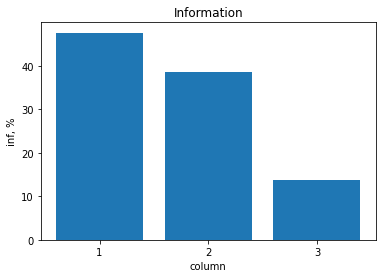

In [39]:
plt.bar([str(i) for i in range(1, pca_components+1)], pca.explained_variance_ratio_*100)
plt.title('Information')
plt.xlabel('column')
plt.ylabel('inf, %')
plt.show()

Потеренная информация

In [40]:
print(f'Потеренная информация: {(1-pca.explained_variance_ratio_.sum())*100} %')

Потеренная информация: 0.016737597437266327 %


Мы потеряли совсем мало информации

Теперь после PCA можно обучать гораздо большее количество итераций за меньшее время

In [41]:
%%time

cat = CatBoostClassifier(verbose=False, n_estimators=1000, 
                         random_seed=42, class_weights=[1, disbalance])

cat.fit(df_train_pca.drop('target', axis=1), df_train_pca[['target']])

CPU times: user 2min 55s, sys: 6.03 s, total: 3min 1s
Wall time: 1min 47s


score on train

In [42]:
best_threshold = pred_train(cat, df_train_pca)

              precision    recall  f1-score   support

         0.0       0.97      0.96      0.97    580393
         1.0       0.54      0.63      0.58     43346

    accuracy                           0.94    623739
   macro avg       0.76      0.79      0.77    623739
weighted avg       0.94      0.94      0.94    623739

threshold: 0.83
SCORE: 0.7725640263212784


score on val

In [43]:
score_cat_pca = pred_val(cat, df_val_pca, best_threshold)

              precision    recall  f1-score   support

         0.0       0.99      0.89      0.94    191074
         1.0       0.41      0.87      0.56     16840

    accuracy                           0.89    207914
   macro avg       0.70      0.88      0.75    207914
weighted avg       0.94      0.89      0.91    207914

threshold: 0.83
SCORE: 0.7473166172614165


Лучше не стало, попробуем другие модели

#### XGB

In [44]:
%%time

xgb = XGBClassifier(learning_rate=0.1,
                    colsample_bytree=0.3, 
                    max_depth=7,
                    n_estimators=100,
                    reg_lambda=4,
                    scale_pos_weight=disbalance,
                    seed=42)

xgb.fit(df_train_pca.drop('target', axis=1), df_train_pca[['target']])

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


CPU times: user 36.3 s, sys: 140 ms, total: 36.5 s
Wall time: 43.7 s


XGBClassifier(colsample_bytree=0.3, max_depth=7, reg_lambda=4,
              scale_pos_weight=13.389770682415909, seed=42)

score on train

In [45]:
best_threshold = pred_train(xgb, df_train_pca)

              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97    580393
         1.0       0.56      0.58      0.57     43346

    accuracy                           0.94    623739
   macro avg       0.76      0.77      0.77    623739
weighted avg       0.94      0.94      0.94    623739

threshold: 0.83
SCORE: 0.7681201558239505


score on val

In [46]:
score_xgb_pca = pred_val(xgb, df_val_pca, best_threshold)

              precision    recall  f1-score   support

         0.0       0.99      0.88      0.93    191074
         1.0       0.41      0.93      0.57     16840

    accuracy                           0.89    207914
   macro avg       0.70      0.91      0.75    207914
weighted avg       0.95      0.89      0.90    207914

threshold: 0.83
SCORE: 0.7509214781631175


#### LogisticRegression

In [47]:
%%time

log_reg = LogisticRegression(random_state=42, class_weight={0:1.,1:disbalance})

log_reg.fit(df_train_pca.drop('target', axis=1), df_train_pca[['target']])

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


CPU times: user 1.97 s, sys: 903 ms, total: 2.87 s
Wall time: 2.05 s


LogisticRegression(class_weight={0: 1.0, 1: 13.389770682415909},
                   random_state=42)

score on train

In [48]:
best_threshold = pred_train(log_reg, df_train_pca)

              precision    recall  f1-score   support

         0.0       0.94      0.62      0.75    580393
         1.0       0.09      0.49      0.15     43346

    accuracy                           0.61    623739
   macro avg       0.52      0.56      0.45    623739
weighted avg       0.88      0.61      0.71    623739

threshold: 0.52
SCORE: 0.4481438455491846


score on val

In [49]:
score_log_reg_pca = pred_val(log_reg, df_val_pca, best_threshold)

              precision    recall  f1-score   support

         0.0       0.93      0.62      0.74    191074
         1.0       0.09      0.45      0.16     16840

    accuracy                           0.60    207914
   macro avg       0.51      0.54      0.45    207914
weighted avg       0.86      0.60      0.69    207914

threshold: 0.52
SCORE: 0.44897227784282745


#### RandomForest

In [50]:
%%time

rf = RandomForestClassifier(random_state=42, class_weight={0:1.,1:disbalance}, min_samples_leaf=3, n_estimators=100)

rf.fit(df_train_pca.drop('target', axis=1), df_train_pca[['target']])

<timed exec>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


CPU times: user 2min 29s, sys: 327 ms, total: 2min 30s
Wall time: 2min 30s


RandomForestClassifier(class_weight={0: 1.0, 1: 13.389770682415909},
                       min_samples_leaf=3, random_state=42)

score on train

In [51]:
best_threshold = pred_train(rf, df_train_pca)

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98    580393
         1.0       0.72      0.84      0.77     43346

    accuracy                           0.97    623739
   macro avg       0.85      0.91      0.88    623739
weighted avg       0.97      0.97      0.97    623739

threshold: 0.63
SCORE: 0.8772949535042349


score on val

In [52]:
score_rf_pca = pred_val(rf, df_val_pca, best_threshold)

              precision    recall  f1-score   support

         0.0       0.97      0.91      0.94    191074
         1.0       0.41      0.72      0.52     16840

    accuracy                           0.89    207914
   macro avg       0.69      0.81      0.73    207914
weighted avg       0.93      0.89      0.91    207914

threshold: 0.63
SCORE: 0.731183796502044


### Результат

In [53]:
pd.DataFrame({'score': [score_bl_1, score_bl_2, score_bl_3, score_bl_4, score_bl_5, score_cat, score_cat_pca, score_xgb_pca, score_log_reg_pca, score_rf_pca]}, 
          index = ["baseline 1 (top 1)", "baseline 2 (top 2)", "baseline 3 (top 3)", "baseline 4 (last buy)", "baseline 5 (top 2 + last buy)", 
                   "CatBoost", "CatBoost with PCA", "XGBoost with PCA", "Logistic Regression with PCA", "Random Forest with PCA"]).sort_values(by='score', ascending=False)

,score
XGBoost with PCA,0.750921
baseline 2 (top 2),0.749780
baseline 5 (top 2 + last buy),0.749041
baseline 1 (top 1),0.747702
CatBoost,0.747347
CatBoost with PCA,0.747317
baseline 3 (top 3),0.743471
Random Forest with PCA,0.731184
baseline 4 (last buy),0.479148
Logistic Regression with PCA,0.448972


Анализ результатов:

Видно, что 2 алгоритм baseline очень хорошо себя показывает на валидационной выборе и его смог превзойти только XGB с тщательно подобранными параметрами в ручную.

LogisticRegression показал себя очень плохо, значит наши классы не являются линейно разделимыми.

Для тщательной настройки параметров я выбрал XGB, так как это изначально более сильная модель при хорошо заданных параметрах. Зато для первичного рещультата очень хорошо подходит CatBoost, так как он более автономный, а как видно результат тоже очень неплохой. 2 эти модели одного класса, что нам подсказывает один и тот же threshold=0.83.

#### Выбираем модель XGB

In [54]:
threshold = 0.83

Confusion Matrix

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


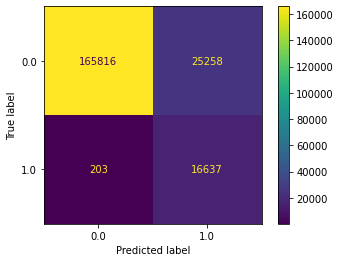

In [55]:
plot_confusion_matrix(xgb, df_val_pca.drop('target', axis=1), df_val_pca.target.values)
plt.show()

Важность признаков

In [56]:
sorted_weight = dict(sorted(xgb.get_booster().get_score(importance_type='weight').items(), key=lambda item: item[1], reverse=True))
sorted_weight

{'id': 2220,
 '3': 1499,
 '1': 1370,
 '2': 1175,
 'buy_time': 784,
 'vas_id': 302,
 'mean_target_vas_id': 252}

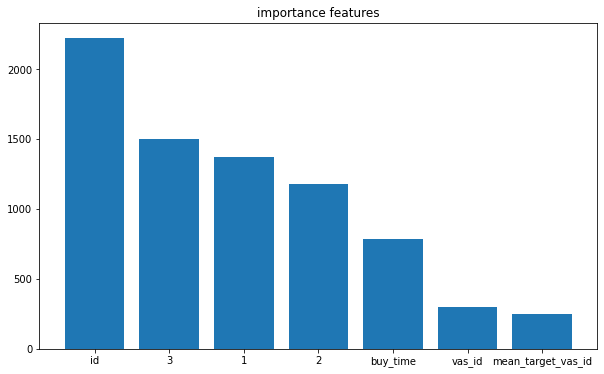

In [57]:
plt.figure(figsize=(10, 6))
plt.bar(sorted_weight.keys(), sorted_weight.values())
plt.title('importance features')
plt.show()

Видно, что наибольшую значимость имеет id, значит выбор тарифа зависит в большей степени от истории абонента, которому предлагается тариф, от чего он отказывался и на что он соглашался. Так же большую роль играют анонимированные признаки, так как они содержат большую разнородность данных собранную с 200+ столбцов. А вот созданный нами признак имеет малую значимость, видимо модель и без него учитывает среднюю подключаемость тарифов.

#### Сохраним данные для последующего использования

In [58]:
with open("/content/drive/MyDrive/Colab Notebooks/xgb.pkl", "wb") as f:
    pickle.dump(xgb, f)
with open("/content/drive/MyDrive/Colab Notebooks/pca.pkl", "wb") as f:
    pickle.dump(pca, f)
rates.to_csv("/content/drive/MyDrive/Colab Notebooks/rates.csv")

### *** check point ***

Загрузим данные для предсказания

In [4]:
with open("/content/drive/MyDrive/Colab Notebooks/xgb.pkl", "rb") as f:
    xgb = pickle.load(f)
with open("/content/drive/MyDrive/Colab Notebooks/pca.pkl", "rb") as f:
    pca = pickle.load(f)
rates = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/rates.csv")
df_features = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/df_features.csv")

### Pipline

In [5]:
def get_answers(input_file_name, threshold=0.83, const_features=['75', '81', '85', '139', '203']):
  df_test = pd.read_csv(input_file_name)
  df_test = df_test.merge(df_features, on='id', how='left')
  df_test = df_test.drop(const_features, axis=1)
  df_test = df_test.merge(rates, how='left', on='vas_id')
  df_test = pd.concat([df_test[['id',	'vas_id',	'buy_time', 'mean_target_vas_id']], 
                          pd.DataFrame(data=pca.transform(df_test.drop(['id',	'vas_id',	'buy_time', 'mean_target_vas_id'], axis=1)), 
                                       index=df_test.index, columns=[str(i) for i in range(1, pca.n_components+1)])], axis=1)
  predict_target = (xgb.predict_proba(df_test)[:,1] > threshold).astype(float)
  result = pd.concat([df_test[['id',	'vas_id',	'buy_time']], pd.DataFrame(data=predict_target, index=df_test.index, columns=['target'])], axis=1)
  result.to_csv("/answers_test.csv")
  print('finish!')

### Test

In [6]:
df_test = pd.read_csv('/data_test.csv')
df_test.head(5)

,Unnamed: 0,id,vas_id,buy_time
0,0,3130519.0,2.0,1.548018e+09
1,1,2000860.0,4.0,1.548018e+09
2,2,1099444.0,2.0,1.546808e+09
3,3,1343255.0,5.0,1.547413e+09
4,4,1277040.0,2.0,1.546808e+09


In [7]:
df_test.id.isna().argmax()

71231

In [8]:
df_test.iloc[71231]

Unnamed: 0    0.0
id            NaN
vas_id        NaN
buy_time      NaN
Name: 71231, dtype: float64

Как видно, в исходных данных есть NaN строка, с ней можно поступить по разному, всё равно предсказать значение, например более вероятное (0), или исключить её. Я выбрал исключить её.

In [9]:
df_test = df_test.drop(71231, axis=0).reset_index().drop(['Unnamed: 0', 'index'], axis=1)
df_test.head()

,id,vas_id,buy_time
0,3130519.0,2.0,1.548018e+09
1,2000860.0,4.0,1.548018e+09
2,1099444.0,2.0,1.546808e+09
3,1343255.0,5.0,1.547413e+09
4,1277040.0,2.0,1.546808e+09


In [10]:
df_test.to_csv('/data_test.csv', index=False)

### Final result

In [11]:
get_answers('/data_test.csv')

finish!


In [12]:
df_answers_test = pd.read_csv("/answers_test.csv")
df_answers_test.head()

,Unnamed: 0,id,vas_id,buy_time,target
0,0,3130519.0,2.0,1.548018e+09,0.0
1,1,2000860.0,4.0,1.548018e+09,0.0
2,2,1099444.0,2.0,1.546808e+09,0.0
3,3,1343255.0,5.0,1.547413e+09,0.0
4,4,1277040.0,2.0,1.546808e+09,0.0


In [13]:
df_answers_test.target.value_counts()

0.0    84305
1.0    21274
Name: target, dtype: int64